Creation of county-level demographic data using 
1. American Community Survey data via python package CensusData (install: pip install CensusData; documentation: https://jtleider.github.io/censusdata/)
2. domestic and international flight passenger data from the US Bureau of Transportation Statistics (https://www.bts.gov/airport-rankings-2018)
3. shelter-in-place/stay-at-home order data from the New York Times (https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html), the San Francisco Chronicle (https://www.sfchronicle.com/bayarea/article/Bay-Area-to-shelter-in-place-What-you-need-15135087.php), and the Alameda County government (https://www.acgov.org/documents/Final-Order-to-Shelter-In-Place.pdf)
5. prison and jail population data from the Vera Institute of Justice (https://github.com/vera-institute/incarceration_trends)
6. Diabetes Atlas (https://gis.cdc.gov/grasp/diabetes/DiabetesAtlas.html#)
7. Nursing Home Quality Data (

Rather than using census data (the last census was in 2010), used 1 year American Community Survey estimates.  Though these are less accurate, they are the most recent estimates available from the US Census.  Also, although the 1-year ACS data is only available for populations >=65,000, this is a good limit to impose to keep the number of areas examined in check.

In [1]:
import pandas as pd
import numpy as np
import censusdata
import re
from uszipcode import SearchEngine
import rpy2.robjects as robjects

In [2]:
# https://jtleider.github.io/censusdata/example2.html
pd.set_option('display.expand_frame_repr', False) # the frame will be huge, don't expand
pd.set_option('display.precision', 4)

### Census/Population Data

In [3]:
# searched 2018 1-year ACS data profiles for specific fields to download using search terms like 'income', 'poverty', 'insurance', 'transportation', etc.
# DP = data profile table; explanation of table types at https://www.census.gov/programs-surveys/acs/guidance/which-data-tool/table-ids-explained.html

censusdata.search('acs1', 2018, 'label', 'transportation', 'profile')

[('DP03_0021E',
  'SELECTED ECONOMIC CHARACTERISTICS',
  'Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Public transportation (excluding taxicab)'),
 ('DP03_0021PE',
  'SELECTED ECONOMIC CHARACTERISTICS',
  'Percent Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Public transportation (excluding taxicab)'),
 ('DP03_0031E',
  'SELECTED ECONOMIC CHARACTERISTICS',
  'Estimate!!OCCUPATION!!Civilian employed population 16 years and over!!Production, transportation, and material moving occupations'),
 ('DP03_0031PE',
  'SELECTED ECONOMIC CHARACTERISTICS',
  'Percent Estimate!!OCCUPATION!!Civilian employed population 16 years and over!!Production, transportation, and material moving occupations'),
 ('DP03_0038E',
  'SELECTED ECONOMIC CHARACTERISTICS',
  'Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Transportation and warehousing, and utilities'),
 ('DP03_0038PE',
  'SELECTED ECONOMIC CHARACTERISTICS',
  'Percent Estimate!!INDUSTRY!!Civilian employed po

In [4]:
fields = ['DP02_0015E', 'DP03_0033E', 'DP03_0041E', 'DP03_0042E', 'DP03_0043E', 
          'DP03_0035E', 'DP03_0037E', 'DP03_0038E', 'DP03_0046E', 'DP03_0119PE', 
          'DP03_0088E',  'DP03_0021PE', 'DP05_0001E', 'DP05_0029E', 'DP03_0095E', 
          'DP04_0143PE', 'DP05_0065E', 'DP05_0038E', 'DP05_0071E', 'DP02_0092E']
counties = censusdata.download('acs1', 2018, censusdata.censusgeo([('county', '*')]), 
                               fields, tabletype = 'profile')

In [5]:
counties.describe()

,DP02_0015E,DP03_0033E,DP03_0041E,DP03_0042E,DP03_0043E,DP03_0035E,DP03_0037E,DP03_0038E,DP03_0046E,DP03_0119PE,DP03_0088E,DP03_0021PE,DP05_0001E,DP05_0029E,DP03_0095E,DP04_0143PE,DP05_0065E,DP05_0038E,DP05_0071E,DP02_0092E
count,827.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,838.0000,838.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.2700e+02
mean,2.5905,-2.3847e+06,-2.3663e+06,-2.3492e+06,-2.3705e+06,-2.3714e+06,-2.3688e+06,-2.3777e+06,1.6239e+05,9.3678,31799.4320,-1.5513e+07,3.3371e+05,5.1702e+04,3.2934e+05,-8.8915e+08,-1.1436e+06,-4.4108e+07,6.8112e+04,5.1980e+04
std,0.2503,4.8824e+07,4.8825e+07,4.8826e+07,4.8825e+07,4.8825e+07,4.8825e+07,4.8824e+07,2.9152e+05,5.2102,8072.5366,1.2366e+08,5.8727e+05,8.2760e+04,5.8246e+05,5.4249e+06,3.4546e+07,2.0557e+08,2.4171e+05,1.7515e+05
min,1.9000,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,1.5513e+04,1.3000,10080.0000,-1.0000e+09,6.2607e+04,6.3590e+03,5.7066e+04,-1.0000e+09,-1.0000e+09,-1.0000e+09,2.2600e+02,2.6200e+02
25%,2.4100,5.0925e+02,3.5752e+03,1.0258e+04,4.0738e+03,4.5378e+03,5.0508e+03,2.2002e+03,4.3710e+04,5.9000,26713.7500,3.0000e-01,9.5300e+04,1.6251e+04,9.3264e+04,-8.8889e+08,4.9198e+03,3.1640e+03,4.9462e+03,3.8610e+03
50%,2.5500,9.4000e+02,7.0000e+03,1.7369e+04,7.1555e+03,8.1090e+03,8.9770e+03,3.8195e+03,7.4613e+04,8.5000,30535.5000,7.0000e-01,1.5904e+05,2.6132e+04,1.5672e+05,-8.8889e+08,1.4177e+04,1.1031e+04,1.2616e+04,9.0510e+03
75%,2.7100,1.6915e+03,1.8371e+04,3.9902e+04,1.6001e+04,1.5998e+04,1.8470e+04,8.3798e+03,1.6498e+05,11.5000,35472.7500,1.8000e+00,3.3089e+05,5.2966e+04,3.2789e+05,-8.8889e+08,4.3473e+04,3.8736e+04,4.3911e+04,3.1505e+04
max,4.1100,6.6139e+04,6.4235e+05,1.0316e+06,5.8385e+05,4.5555e+05,5.0494e+05,3.1794e+05,5.0014e+06,49.2000,74911.0000,6.0700e+01,1.0106e+07,1.3760e+06,1.0035e+07,-8.8889e+08,1.2582e+06,1.2046e+06,4.9153e+06,3.4400e+06


In [6]:
# apparently censusdata doesn't retrieve labels with the download, so creating a dictionary with that info now
field_info = dict()
for field in fields:
    field_info[field] = censusdata.variable_info.censustable('acs1', 2018, table=re.sub("_.+$", "", field)).get(field)

for key in field_info.keys():
    print(key, "\t", field_info.get(key).get('label'))

DP02_0015E 	 Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Average household size
DP03_0033E 	 Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining
DP03_0041E 	 Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Professional, scientific, and management, and administrative and waste management services
DP03_0042E 	 Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Educational services, and health care and social assistance
DP03_0043E 	 Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Arts, entertainment, and recreation, and accommodation and food services
DP03_0035E 	 Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Manufacturing
DP03_0037E 	 Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Retail trade
DP03_0038E 	 Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Transportation and warehousing, and utiliti

In [7]:
# creating shorter labels...
labels = ['household_size', 'empl_agriculture', 'empl_professional', 'empl_social', 'empl_services', 
          'empl_manufacturing', 'empl_retail', 'empl_transp_utilities', 'employed',
          'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population', 'pop_65_plus', 
          'health_ins', 'avg_rent_prc_income', 'aa_and_mixed', 'aa', 'latino', 'immigrant']

In [8]:
counties.columns = labels

In [9]:
counties.describe()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,avg_income,prc_public_transp,population,pop_65_plus,health_ins,avg_rent_prc_income,aa_and_mixed,aa,latino,immigrant
count,827.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,838.0000,838.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.2700e+02
mean,2.5905,-2.3847e+06,-2.3663e+06,-2.3492e+06,-2.3705e+06,-2.3714e+06,-2.3688e+06,-2.3777e+06,1.6239e+05,9.3678,31799.4320,-1.5513e+07,3.3371e+05,5.1702e+04,3.2934e+05,-8.8915e+08,-1.1436e+06,-4.4108e+07,6.8112e+04,5.1980e+04
std,0.2503,4.8824e+07,4.8825e+07,4.8826e+07,4.8825e+07,4.8825e+07,4.8825e+07,4.8824e+07,2.9152e+05,5.2102,8072.5366,1.2366e+08,5.8727e+05,8.2760e+04,5.8246e+05,5.4249e+06,3.4546e+07,2.0557e+08,2.4171e+05,1.7515e+05
min,1.9000,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,1.5513e+04,1.3000,10080.0000,-1.0000e+09,6.2607e+04,6.3590e+03,5.7066e+04,-1.0000e+09,-1.0000e+09,-1.0000e+09,2.2600e+02,2.6200e+02
25%,2.4100,5.0925e+02,3.5752e+03,1.0258e+04,4.0738e+03,4.5378e+03,5.0508e+03,2.2002e+03,4.3710e+04,5.9000,26713.7500,3.0000e-01,9.5300e+04,1.6251e+04,9.3264e+04,-8.8889e+08,4.9198e+03,3.1640e+03,4.9462e+03,3.8610e+03
50%,2.5500,9.4000e+02,7.0000e+03,1.7369e+04,7.1555e+03,8.1090e+03,8.9770e+03,3.8195e+03,7.4613e+04,8.5000,30535.5000,7.0000e-01,1.5904e+05,2.6132e+04,1.5672e+05,-8.8889e+08,1.4177e+04,1.1031e+04,1.2616e+04,9.0510e+03
75%,2.7100,1.6915e+03,1.8371e+04,3.9902e+04,1.6001e+04,1.5998e+04,1.8470e+04,8.3798e+03,1.6498e+05,11.5000,35472.7500,1.8000e+00,3.3089e+05,5.2966e+04,3.2789e+05,-8.8889e+08,4.3473e+04,3.8736e+04,4.3911e+04,3.1505e+04
max,4.1100,6.6139e+04,6.4235e+05,1.0316e+06,5.8385e+05,4.5555e+05,5.0494e+05,3.1794e+05,5.0014e+06,49.2000,74911.0000,6.0700e+01,1.0106e+07,1.3760e+06,1.0035e+07,-8.8889e+08,1.2582e+06,1.2046e+06,4.9153e+06,3.4400e+06


In [10]:
# drop avg_rent_prc_income since it doesn't seem very informative 
counties = counties.drop(columns=['avg_rent_prc_income'])

In [11]:
counties.describe()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,avg_income,prc_public_transp,population,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant
count,827.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,838.0000,838.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.2700e+02
mean,2.5905,-2.3847e+06,-2.3663e+06,-2.3492e+06,-2.3705e+06,-2.3714e+06,-2.3688e+06,-2.3777e+06,1.6239e+05,9.3678,31799.4320,-1.5513e+07,3.3371e+05,5.1702e+04,3.2934e+05,-1.1436e+06,-4.4108e+07,6.8112e+04,5.1980e+04
std,0.2503,4.8824e+07,4.8825e+07,4.8826e+07,4.8825e+07,4.8825e+07,4.8825e+07,4.8824e+07,2.9152e+05,5.2102,8072.5366,1.2366e+08,5.8727e+05,8.2760e+04,5.8246e+05,3.4546e+07,2.0557e+08,2.4171e+05,1.7515e+05
min,1.9000,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,1.5513e+04,1.3000,10080.0000,-1.0000e+09,6.2607e+04,6.3590e+03,5.7066e+04,-1.0000e+09,-1.0000e+09,2.2600e+02,2.6200e+02
25%,2.4100,5.0925e+02,3.5752e+03,1.0258e+04,4.0738e+03,4.5378e+03,5.0508e+03,2.2002e+03,4.3710e+04,5.9000,26713.7500,3.0000e-01,9.5300e+04,1.6251e+04,9.3264e+04,4.9198e+03,3.1640e+03,4.9462e+03,3.8610e+03
50%,2.5500,9.4000e+02,7.0000e+03,1.7369e+04,7.1555e+03,8.1090e+03,8.9770e+03,3.8195e+03,7.4613e+04,8.5000,30535.5000,7.0000e-01,1.5904e+05,2.6132e+04,1.5672e+05,1.4177e+04,1.1031e+04,1.2616e+04,9.0510e+03
75%,2.7100,1.6915e+03,1.8371e+04,3.9902e+04,1.6001e+04,1.5998e+04,1.8470e+04,8.3798e+03,1.6498e+05,11.5000,35472.7500,1.8000e+00,3.3089e+05,5.2966e+04,3.2789e+05,4.3473e+04,3.8736e+04,4.3911e+04,3.1505e+04
max,4.1100,6.6139e+04,6.4235e+05,1.0316e+06,5.8385e+05,4.5555e+05,5.0494e+05,3.1794e+05,5.0014e+06,49.2000,74911.0000,6.0700e+01,1.0106e+07,1.3760e+06,1.0035e+07,1.2582e+06,1.2046e+06,4.9153e+06,3.4400e+06


In [12]:
counties.head()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,avg_income,prc_public_transp,population,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant
"Morgan County, Alabama: Summary level: 050, state:01> county:103",2.56,580,6009,10431,4473,11938,5507,3039,53742,9.9,27742,0.4,119089,20464,117677,17794,17107,10067,4827.0
"Kings County, California: Summary level: 050, state:06> county:031",3.15,7797,3901,11372,4707,3752,4899,2329,52644,15.6,22628,0.5,151366,15413,136372,12375,10428,83200,25254.0
"Monterey County, California: Summary level: 050, state:06> county:053",3.31,30494,19232,37518,20736,12420,17109,7415,190707,10.5,30674,1.3,435594,59491,419413,15458,11753,257572,134282.0
"Nevada County, California: Summary level: 050, state:06> county:057",2.37,596,7285,9199,5133,1562,4717,3022,44505,5.1,37645,0.1,99696,27746,98472,825,534,9644,5038.0
"Shasta County, California: Summary level: 050, state:06> county:089",2.59,743,6543,17734,7999,3077,8953,3488,69649,9.5,28144,0.8,180040,37027,178552,3596,2080,18560,11759.0


In [13]:
# make county, state columns from index to use for joining the airport data
county = counties.index
state = [re.sub(": Summary.+$", "", x.name) for x in county] # move "County, State" to state list
counties['county'] = [re.sub(", .+$", "", x) for x in state] # move just "County" to county list
counties['state'] = [re.sub("^.*, ", "", x) for x in state] # remove "County, " to have just "State" in state list

In [14]:
counties.head()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,prc_public_transp,population,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant,county,state
"Morgan County, Alabama: Summary level: 050, state:01> county:103",2.56,580,6009,10431,4473,11938,5507,3039,53742,9.9,...,0.4,119089,20464,117677,17794,17107,10067,4827.0,Morgan County,Alabama
"Kings County, California: Summary level: 050, state:06> county:031",3.15,7797,3901,11372,4707,3752,4899,2329,52644,15.6,...,0.5,151366,15413,136372,12375,10428,83200,25254.0,Kings County,California
"Monterey County, California: Summary level: 050, state:06> county:053",3.31,30494,19232,37518,20736,12420,17109,7415,190707,10.5,...,1.3,435594,59491,419413,15458,11753,257572,134282.0,Monterey County,California
"Nevada County, California: Summary level: 050, state:06> county:057",2.37,596,7285,9199,5133,1562,4717,3022,44505,5.1,...,0.1,99696,27746,98472,825,534,9644,5038.0,Nevada County,California
"Shasta County, California: Summary level: 050, state:06> county:089",2.59,743,6543,17734,7999,3077,8953,3488,69649,9.5,...,0.8,180040,37027,178552,3596,2080,18560,11759.0,Shasta County,California


In [15]:
counties[counties['county'] == "New York County"]

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,prc_public_transp,population,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant,county,state
"New York County, New York: Summary level: 050, state:36> county:061",2.08,1113,195150,209196,93400,22918,58324,25591,901880,12.1,...,59.9,1628701,268834,1617657,275247,236356,421023,475954.0,New York County,New York


In [16]:
counties[counties['county'] == "Alameda County"]

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,prc_public_transp,population,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant,county,state
"Alameda County, California: Summary level: 050, state:06> county:001",2.84,4405,180270,192425,72367,86012,76344,44602,882648,5.1,...,15.7,1666753,230510,1657847,202280,172152,373040,535695.0,Alameda County,California


In [17]:
counties.shape

(838, 21)

In [18]:
fips = re.compile("^.+, state:(\d+).*county:(\d+).*$")

In [19]:
found = fips.match(str(counties.index[0]))

In [20]:
found.group(1)+found.group(2)

'01103'

In [21]:
# add column of FIPS codes for joining with area (sq. mi.) data
codes = list()
for x in counties.index:
    found = fips.match(str(x))
    codes.append(found.group(1)+found.group(2))

In [22]:
counties['FIPS'] = codes

In [23]:
counties.head()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,population,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant,county,state,FIPS
"Morgan County, Alabama: Summary level: 050, state:01> county:103",2.56,580,6009,10431,4473,11938,5507,3039,53742,9.9,...,119089,20464,117677,17794,17107,10067,4827.0,Morgan County,Alabama,01103
"Kings County, California: Summary level: 050, state:06> county:031",3.15,7797,3901,11372,4707,3752,4899,2329,52644,15.6,...,151366,15413,136372,12375,10428,83200,25254.0,Kings County,California,06031
"Monterey County, California: Summary level: 050, state:06> county:053",3.31,30494,19232,37518,20736,12420,17109,7415,190707,10.5,...,435594,59491,419413,15458,11753,257572,134282.0,Monterey County,California,06053
"Nevada County, California: Summary level: 050, state:06> county:057",2.37,596,7285,9199,5133,1562,4717,3022,44505,5.1,...,99696,27746,98472,825,534,9644,5038.0,Nevada County,California,06057
"Shasta County, California: Summary level: 050, state:06> county:089",2.59,743,6543,17734,7999,3077,8953,3488,69649,9.5,...,180040,37027,178552,3596,2080,18560,11759.0,Shasta County,California,06089


To get land area information, ended up having to download data from archived US Census site since I couldn't figure out how to easily get this info through censusdata module.  The land area is from the 2010 census, but much less likely to have changed in the past 10 years than the population/demographics data.

https://web.archive.org/web/20150807220054/http://quickfacts.census.gov/qfd/download_data.html

data itself is available at: https://web.archive.org/web/20150821182814/http://quickfacts.census.gov/qfd/download/DataSet.txt

In [24]:
# get land area for the given counties

quickFacts = pd.read_csv("stateCounty_quickFacts.txt", dtype={'fips':str, 'LND110210':float})

In [25]:
quickFacts # only needs fips and LND110210

,fips,PST045214,PST045213,PST040210,PST120214,PST120213,POP010210,AGE135213,AGE295213,AGE775213,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,00000,318857056,316497531,308758105,3.3,2.5,308745538,6.3,23.3,14.1,...,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3.5319e+06,87.4
1,01000,4849377,4833996,4780127,1.4,1.1,4779736,6.1,23.0,14.9,...,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,5.0645e+04,94.4
2,01001,55395,55136,54571,1.5,1.0,54571,6.1,25.4,13.5,...,0.7,31.7,0,0,598175,12003,88157,131,5.9444e+02,91.8
3,01003,200111,195443,182265,9.8,7.2,182265,5.7,22.4,18.1,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1.5898e+03,114.6
4,01005,26887,26978,27457,-2.1,-1.7,27457,5.8,21.1,15.9,...,0.0,27.0,0,0,188337,6334,0,8,8.8488e+02,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,56037,45010,45205,43806,2.7,3.2,43806,7.6,27.2,9.0,...,3.8,27.2,0,437493,898189,22843,150439,227,1.0427e+04,4.2
3191,56039,22930,22375,21294,7.7,5.1,21294,5.9,19.2,11.8,...,3.3,25.3,0,0,515644,25688,327363,145,3.9954e+03,5.3
3192,56041,20904,21031,21118,-1.0,-0.4,21118,7.6,29.5,10.5,...,2.2,15.9,0,159375,413983,20626,35497,40,2.0813e+03,10.1
3193,56043,8322,8450,8533,-2.5,-1.0,8533,5.8,24.4,19.2,...,0.0,26.9,0,12128,98308,12596,10175,4,2.2386e+03,3.8


In [26]:
quickFacts = quickFacts[["fips", "LND110210"]]

In [27]:
quickFacts.head()

,fips,LND110210
0,00000,3.5319e+06
1,01000,5.0645e+04
2,01001,5.9444e+02
3,01003,1.5898e+03
4,01005,8.8488e+02


In [28]:
counties.iloc[0]['FIPS']

'01103'

In [29]:
area = list()
for x in range(counties.shape[0]):
    results = quickFacts.loc[quickFacts["fips"] == counties.iloc[x]['FIPS'], "LND110210"]
    try:
        value = float(results)
        area.append(value)
    except:
        area.append(None)

In [30]:
counties["area"] = area

In [31]:
counties.describe()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,avg_income,prc_public_transp,population,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant,area
count,827.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,838.0000,838.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.2700e+02,827.0000
mean,2.5905,-2.3847e+06,-2.3663e+06,-2.3492e+06,-2.3705e+06,-2.3714e+06,-2.3688e+06,-2.3777e+06,1.6239e+05,9.3678,31799.4320,-1.5513e+07,3.3371e+05,5.1702e+04,3.2934e+05,-1.1436e+06,-4.4108e+07,6.8112e+04,5.1980e+04,1066.8997
std,0.2503,4.8824e+07,4.8825e+07,4.8826e+07,4.8825e+07,4.8825e+07,4.8825e+07,4.8824e+07,2.9152e+05,5.2102,8072.5366,1.2366e+08,5.8727e+05,8.2760e+04,5.8246e+05,3.4546e+07,2.0557e+08,2.4171e+05,1.7515e+05,1816.4262
min,1.9000,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,1.5513e+04,1.3000,10080.0000,-1.0000e+09,6.2607e+04,6.3590e+03,5.7066e+04,-1.0000e+09,-1.0000e+09,2.2600e+02,2.6200e+02,15.0300
25%,2.4100,5.0925e+02,3.5752e+03,1.0258e+04,4.0738e+03,4.5378e+03,5.0508e+03,2.2002e+03,4.3710e+04,5.9000,26713.7500,3.0000e-01,9.5300e+04,1.6251e+04,9.3264e+04,4.9198e+03,3.1640e+03,4.9462e+03,3.8610e+03,434.6000
50%,2.5500,9.4000e+02,7.0000e+03,1.7369e+04,7.1555e+03,8.1090e+03,8.9770e+03,3.8195e+03,7.4613e+04,8.5000,30535.5000,7.0000e-01,1.5904e+05,2.6132e+04,1.5672e+05,1.4177e+04,1.1031e+04,1.2616e+04,9.0510e+03,629.0000
75%,2.7100,1.6915e+03,1.8371e+04,3.9902e+04,1.6001e+04,1.5998e+04,1.8470e+04,8.3798e+03,1.6498e+05,11.5000,35472.7500,1.8000e+00,3.3089e+05,5.2966e+04,3.2789e+05,4.3473e+04,3.8736e+04,4.3911e+04,3.1505e+04,909.9550
max,4.1100,6.6139e+04,6.4235e+05,1.0316e+06,5.8385e+05,4.5555e+05,5.0494e+05,3.1794e+05,5.0014e+06,49.2000,74911.0000,6.0700e+01,1.0106e+07,1.3760e+06,1.0035e+07,1.2582e+06,1.2046e+06,4.9153e+06,3.4400e+06,24607.9000


In [32]:
counties.loc[counties.area == None,]

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant,county,state,FIPS,area


In [33]:
counties[(counties.county == "New York County") | (counties.county == "Alameda County")]
# note that while Alameda County, CA and New York County, NY have very similar population sizes, Alameda County has
# vastly more land area

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant,county,state,FIPS,area
"Alameda County, California: Summary level: 050, state:06> county:001",2.84,4405,180270,192425,72367,86012,76344,44602,882648,5.1,...,230510,1657847,202280,172152,373040,535695.0,Alameda County,California,06001,739.02
"New York County, New York: Summary level: 050, state:36> county:061",2.08,1113,195150,209196,93400,22918,58324,25591,901880,12.1,...,268834,1617657,275247,236356,421023,475954.0,New York County,New York,36061,22.83


In [34]:
# convert full name of state in "state" column to its appropriate 2-letter abbreviation
# state abbreviation dictionary from https://gist.github.com/rogerallen/1583593
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [35]:
state = list()

for x in range(counties.shape[0]):
    state.append(us_state_abbrev[counties.iloc[x]["state"]])
counties["state"] = state

In [36]:
counties[(counties.county == "New York County") | (counties.county == "Alameda County")]

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,pop_65_plus,health_ins,aa_and_mixed,aa,latino,immigrant,county,state,FIPS,area
"Alameda County, California: Summary level: 050, state:06> county:001",2.84,4405,180270,192425,72367,86012,76344,44602,882648,5.1,...,230510,1657847,202280,172152,373040,535695.0,Alameda County,CA,06001,739.02
"New York County, New York: Summary level: 050, state:36> county:061",2.08,1113,195150,209196,93400,22918,58324,25591,901880,12.1,...,268834,1617657,275247,236356,421023,475954.0,New York County,NY,36061,22.83


## Add Obesity Data from CDC


county-level obesity data downloaded from: https://gis.cdc.gov/grasp/diabetes/DiabetesAtlas.html#

In [37]:
obesity = pd.read_csv("DiabetesAtlasCountyData_obesity.csv", header=None)

In [38]:
obesity.head()

,0,1,2,3,4,5
0,Obesity,Total (Total),Adults Aged 20+ Years,Age-Adjusted Percentage,U.S. Counties,2016
1,Data downloaded on 21-April-2020,NaN,NaN,NaN,NaN,NaN
2,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3,Autauga County,Alabama,1001,33.2,27.2,39.5
4,Baldwin County,Alabama,1003,31.1,28,34.4


In [39]:
obesity = obesity.drop([0,1], axis=0) # drop that first two rows
obesity.head()

,0,1,2,3,4,5
2,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3,Autauga County,Alabama,1001,33.2,27.2,39.5
4,Baldwin County,Alabama,1003,31.1,28,34.4
5,Barbour County,Alabama,1005,41.7,34.1,49.5
6,Bibb County,Alabama,1007,37.7,30,46.7


In [40]:
names = list(obesity.iloc[0,])
names

['County', 'State', 'CountyFIPS', 'Percentage', 'Lower Limit', ' Upper Limit']

In [41]:
obesity.columns=names
obesity = obesity.drop([2], axis=0)
obesity.head()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3,Autauga County,Alabama,1001,33.2,27.2,39.5
4,Baldwin County,Alabama,1003,31.1,28,34.4
5,Barbour County,Alabama,1005,41.7,34.1,49.5
6,Bibb County,Alabama,1007,37.7,30,46.7
7,Blount County,Alabama,1009,33.7,27.7,39.9


In [42]:
obesity.describe()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
count,3227,3227,3227,3226,3226,3226
unique,1961,53,3227,308,284,382
top,Washington County,Texas,19043,No Data,No Data,No Data
freq,30,254,1,84,84,84


In [43]:
obesity.head()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3,Autauga County,Alabama,1001,33.2,27.2,39.5
4,Baldwin County,Alabama,1003,31.1,28,34.4
5,Barbour County,Alabama,1005,41.7,34.1,49.5
6,Bibb County,Alabama,1007,37.7,30,46.7
7,Blount County,Alabama,1009,33.7,27.7,39.9


In [44]:
obesity.tail()
# also remove last row

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3225,Teton County,Wyoming,56039,12.3,9.6,15.3
3226,Uinta County,Wyoming,56041,35.6,30.3,40.5
3227,Washakie County,Wyoming,56043,28.7,22.9,35.4
3228,Weston County,Wyoming,56045,32.9,27.2,39.5
3229,US Diabetes Surveillance System,www.cdc.gov/diabetes/data,Division of Diabetes Translation - Centers fo...,NaN,NaN,NaN


In [45]:
obesity = obesity.drop([3229], axis=0)
obesity.tail()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3224,Sweetwater County,Wyoming,56037,29.5,25.9,32.9
3225,Teton County,Wyoming,56039,12.3,9.6,15.3
3226,Uinta County,Wyoming,56041,35.6,30.3,40.5
3227,Washakie County,Wyoming,56043,28.7,22.9,35.4
3228,Weston County,Wyoming,56045,32.9,27.2,39.5


In [46]:
obesity.dtypes

County          object
State           object
CountyFIPS      object
Percentage      object
Lower Limit     object
 Upper Limit    object
dtype: object

In [47]:
obesity = obesity.replace("No Data", "-9999")

In [48]:
obesity["FIPS"] = pd.to_numeric(obesity["CountyFIPS"])
obesity["prc_obese"] = pd.to_numeric(obesity["Percentage"])
obesity["lower_lim"] = pd.to_numeric(obesity["Lower Limit"])
obesity["upper_lim"] = pd.to_numeric(obesity[" Upper Limit"])

In [49]:
obesity.dtypes

County           object
State            object
CountyFIPS       object
Percentage       object
Lower Limit      object
 Upper Limit     object
FIPS              int64
prc_obese       float64
lower_lim       float64
upper_lim       float64
dtype: object

In [50]:
counties_noObesity = set(obesity[obesity.prc_obese == -9999]["FIPS"])
counties["numericFIPS"] = pd.to_numeric(counties["FIPS"])

In [51]:
needData = [x in counties_noObesity for x in set(counties["numericFIPS"])]

In [52]:
counties.loc[needData, ["county", "state"]]

# to fill missing data, take mean of the column (the mean without the dummy -9999 values)

,county,state
"Lake County, Illinois: Summary level: 050, state:17> county:097",Lake County,IL
"Tazewell County, Illinois: Summary level: 050, state:17> county:179",Tazewell County,IL
"Clark County, Indiana: Summary level: 050, state:18> county:019",Clark County,IN
"Black Hawk County, Iowa: Summary level: 050, state:19> county:013",Black Hawk County,IA
"Howard County, Maryland: Summary level: 050, state:24> county:027",Howard County,MD
"Rice County, Minnesota: Summary level: 050, state:27> county:131",Rice County,MN
"Mercer County, New Jersey: Summary level: 050, state:34> county:021",Mercer County,NJ
"Wayne County, New York: Summary level: 050, state:36> county:117",Wayne County,NY
"New Hanover County, North Carolina: Summary level: 050, state:37> county:129",New Hanover County,NC
"Rutherford County, North Carolina: Summary level: 050, state:37> county:161",Rutherford County,NC


In [53]:
obesity.loc[obesity["prc_obese"] == -9999, "prc_obese"] = obesity.loc[obesity["prc_obese"] >= 0,"prc_obese"].mean()
obesity.loc[obesity["lower_lim"] == -9999,"lower_lim"] = obesity.loc[obesity["lower_lim"] >= 0,"lower_lim"].mean()
obesity.loc[obesity["upper_lim"] == -9999,"upper_lim"] = obesity.loc[obesity["upper_lim"] >= 0,"upper_lim"].mean()

In [54]:
obesity.describe()

,FIPS,prc_obese,lower_lim,upper_lim
count,3226.0000,3226.0000,3226.0000,3226.0000
mean,31368.2641,32.7571,25.6398,40.6740
std,16315.1419,5.6281,5.5453,7.0319
min,1001.0000,12.3000,6.1000,15.3000
25%,19027.5000,29.0250,21.9000,36.5000
50%,30022.0000,32.8000,25.9500,40.6740
75%,46106.5000,36.5000,29.5000,45.1000
max,72153.0000,57.9000,45.0000,75.4000


In [55]:
counties.columns

Index(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'empl_transp_utilities', 'employed', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
       'aa_and_mixed', 'aa', 'latino', 'immigrant', 'county', 'state', 'FIPS',
       'area', 'numericFIPS'],
      dtype='object')

In [56]:
obesity_data = list()

for x in range(counties.shape[0]):
    fips = counties.iloc[x]["numericFIPS"]
    
    value = obesity.loc[obesity["FIPS"] == fips, "prc_obese"].values[0]
    obesity_data.append(value)

In [57]:
counties["prc_obese"] = obesity_data

In [58]:
counties.head()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,aa_and_mixed,aa,latino,immigrant,county,state,FIPS,area,numericFIPS,prc_obese
"Morgan County, Alabama: Summary level: 050, state:01> county:103",2.56,580,6009,10431,4473,11938,5507,3039,53742,9.9,...,17794,17107,10067,4827.0,Morgan County,AL,01103,579.34,1103,32.1
"Kings County, California: Summary level: 050, state:06> county:031",3.15,7797,3901,11372,4707,3752,4899,2329,52644,15.6,...,12375,10428,83200,25254.0,Kings County,CA,06031,1389.42,6031,29.4
"Monterey County, California: Summary level: 050, state:06> county:053",3.31,30494,19232,37518,20736,12420,17109,7415,190707,10.5,...,15458,11753,257572,134282.0,Monterey County,CA,06053,3280.60,6053,27.6
"Nevada County, California: Summary level: 050, state:06> county:057",2.37,596,7285,9199,5133,1562,4717,3022,44505,5.1,...,825,534,9644,5038.0,Nevada County,CA,06057,957.77,6057,21.5
"Shasta County, California: Summary level: 050, state:06> county:089",2.59,743,6543,17734,7999,3077,8953,3488,69649,9.5,...,3596,2080,18560,11759.0,Shasta County,CA,06089,3775.40,6089,23.3


In [59]:
df1= counties[counties.isna().any(axis=1)]

In [60]:
df1[["FIPS", "county", "state"]]
# just a small number of these, and none are represented in the johns hopkins covid19 US data downloaded, so won't worry about them

,FIPS,county,state
"Caguas Municipio, Puerto Rico: Summary level: 050, state:72> county:025",72025,Caguas Municipio,PR
"Carolina Municipio, Puerto Rico: Summary level: 050, state:72> county:031",72031,Carolina Municipio,PR
"San Juan Municipio, Puerto Rico: Summary level: 050, state:72> county:127",72127,San Juan Municipio,PR
"Trujillo Alto Municipio, Puerto Rico: Summary level: 050, state:72> county:139",72139,Trujillo Alto Municipio,PR
"Arecibo Municipio, Puerto Rico: Summary level: 050, state:72> county:013",72013,Arecibo Municipio,PR
"Mayagüez Municipio, Puerto Rico: Summary level: 050, state:72> county:097",72097,Mayagüez Municipio,PR
"Guaynabo Municipio, Puerto Rico: Summary level: 050, state:72> county:061",72061,Guaynabo Municipio,PR
"Bayamón Municipio, Puerto Rico: Summary level: 050, state:72> county:021",72021,Bayamón Municipio,PR
"Ponce Municipio, Puerto Rico: Summary level: 050, state:72> county:113",72113,Ponce Municipio,PR
"Toa Alta Municipio, Puerto Rico: Summary level: 050, state:72> county:135",72135,Toa Alta Municipio,PR


## Nursing Home Data

In [61]:
cms = pd.read_csv("NursingHome_Provider_Info.csv")

In [62]:
cms.head(2)

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County,Provider County Name,Ownership Type,...,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date
0,015416,ANDALUSIA MANOR,670 MOORE RD,ANDALUSIA,AL,36420,3342224544,190,Covington,For profit - Corporation,...,44,30.667,1,2,0,0.0,0,0,"670 MOORE RD ANDALUSIA, AL 36420 (31.282419, -...",04/01/2020
1,015463,KNOLLWOOD HEALTHCARE,3151-A KNOLLWOOD DRIVE,MOBILE,AL,36693,2516617608,480,Mobile,For profit - Individual,...,20,61.333,1,3,1,32439.0,0,1,"3151-A KNOLLWOOD DRIVE MOBILE, AL 36693 (30.62...",04/01/2020


In [63]:
list(cms.columns)

# average number of residents per day
# zip code  'Adjusted Total Nurse Staffing Hours per Resident per Day',
# 'Staffing Rating',
# 'Staffing Rating Footnote',
# 'RN Staffing Rating',

['Federal Provider Number',
 'Provider Name',
 'Provider Address',
 'Provider City',
 'Provider State',
 'Provider Zip Code',
 'Provider Phone Number',
 'Provider SSA County',
 'Provider County Name',
 'Ownership Type',
 'Number of Certified Beds',
 'Average Number of Residents Per Day',
 'Provider Type',
 'Provider Resides in Hospital',
 'Legal Business Name',
 'Date First Approved to Provide Medicare and Medicaid services',
 'Continuing Care Retirement Community',
 'Special Focus Status',
 'Abuse Icon',
 'Most Recent Health Inspection More Than 2 Years Ago',
 'Provider Changed Ownership in Last 12 Months',
 'With a Resident and Family Council',
 'Automatic Sprinkler Systems in All Required Areas',
 'Overall Rating',
 'Overall Rating Footnote',
 'Health Inspection Rating',
 'Health Inspection Rating Footnote',
 'QM Rating',
 'QM Rating Footnote',
 'Long-Stay QM Rating',
 'Long-Stay QM Rating Footnote',
 'Short-Stay QM Rating',
 'Short-Stay QM Rating Footnote',
 'Staffing Rating',
 'St

In [64]:
len(cms["Federal Provider Number"].unique())
# one row per each home

15436

In [65]:
cms2 = cms[['Provider County Name', 'Provider State', 
            'Number of Certified Beds', 'Average Number of Residents Per Day',
            'Rating Cycle 3 Total Number of Health Deficiencies',
            'Rating Cycle 3 Health Deficiency Score',
            'Total Weighted Health Survey Score', 
            'Overall Rating', 'Health Inspection Rating', 'QM Rating',
            'Number of Facility Reported Incidents', 'Number of Substantiated Complaints',
            'Number of Fines', 'Total Amount of Fines in Dollars',
            'Adjusted Total Nurse Staffing Hours per Resident per Day']]

In [66]:
cms2.head(2)

,Provider County Name,Provider State,Number of Certified Beds,Average Number of Residents Per Day,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Total Weighted Health Survey Score,Overall Rating,Health Inspection Rating,QM Rating,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Fines,Total Amount of Fines in Dollars,Adjusted Total Nurse Staffing Hours per Resident per Day
0,Covington,AL,154,130.1,11,44,30.667,3.0,2.0,3.0,1,2,0,0.0,4.5017
1,Mobile,AL,71,68.7,3,20,61.333,1.0,1.0,3.0,1,3,1,32439.0,NaN


In [67]:
cms2.describe()

,Number of Certified Beds,Average Number of Residents Per Day,Total Weighted Health Survey Score,Overall Rating,Health Inspection Rating,QM Rating,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Fines,Total Amount of Fines in Dollars,Adjusted Total Nurse Staffing Hours per Resident per Day
count,15436.0000,15367.0000,15341.0000,15256.0000,15256.0000,15226.0000,15436.0000,15436.0000,15436.0000,1.5436e+04,14821.0000
mean,106.2429,85.8539,61.0239,3.1682,2.8191,3.6981,1.3839,4.2499,0.4587,1.4541e+04,3.8701
std,60.7812,52.6688,67.1059,1.4253,1.2786,1.2429,3.3499,7.6063,0.8150,4.8768e+04,0.8748
min,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000e+00,1.2159
25%,64.0000,51.2000,20.6670,2.0000,2.0000,3.0000,0.0000,0.0000,0.0000,0.0000e+00,3.3010
50%,99.0000,78.1000,41.3330,3.0000,3.0000,4.0000,0.0000,1.0000,0.0000,0.0000e+00,3.7518
75%,127.0000,107.5000,77.3330,4.0000,4.0000,5.0000,1.0000,5.0000,1.0000,8.1250e+03,4.2651
max,1389.0000,751.0000,1408.6700,5.0000,5.0000,5.0000,73.0000,132.0000,9.0000,1.2584e+06,11.9480


In [68]:
for field in cms2.columns:
    nas = cms2[pd.isna(cms2[field])]
    print(field, ": ", nas.shape[0])

Provider County Name :  0
Provider State :  0
Number of Certified Beds :  0
Average Number of Residents Per Day :  69
Rating Cycle 3 Total Number of Health Deficiencies :  0
Rating Cycle 3 Health Deficiency Score :  0
Total Weighted Health Survey Score :  95
Overall Rating :  180
Health Inspection Rating :  180
QM Rating :  210
Number of Facility Reported Incidents :  0
Number of Substantiated Complaints :  0
Number of Fines :  0
Total Amount of Fines in Dollars :  0
Adjusted Total Nurse Staffing Hours per Resident per Day :  615


In [69]:
cms2[["Number of Certified Beds", "Average Number of Residents Per Day"]].describe()

,Number of Certified Beds,Average Number of Residents Per Day
count,15436.0000,15367.0000
mean,106.2429,85.8539
std,60.7812,52.6688
min,1.0000,1.0000
25%,64.0000,51.2000
50%,99.0000,78.1000
75%,127.0000,107.5000
max,1389.0000,751.0000


In [70]:
cms2["prc_occupied"] = cms2["Average Number of Residents Per Day"] / cms2["Number of Certified Beds"] * 100
cms2[["Number of Certified Beds", "Average Number of Residents Per Day", "prc_occupied"]].describe()

/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Number of Certified Beds,Average Number of Residents Per Day,prc_occupied
count,15436.0000,15367.0000,15367.0000
mean,106.2429,85.8539,81.0498
std,60.7812,52.6688,19.7973
min,1.0000,1.0000,0.9901
25%,64.0000,51.2000,72.6667
50%,99.0000,78.1000,84.9167
75%,127.0000,107.5000,92.1795
max,1389.0000,751.0000,1338.3333


In [71]:
cms.loc[cms2["prc_occupied"] > 900,] # over 900% occupancy based on number of certified beds.  day care center, or yikes?

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County,Provider County Name,Ownership Type,...,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date
8757,676443,THE CENTER AT GRANDE,3219 EAST GRANDE BOULEVARD,TYLER,TX,75707,7195222000,892,Smith,For profit - Corporation,...,0,94.833,1,5,1,44071.0,0,1,NaN,04/01/2020


In [72]:
cms2.loc[cms2["prc_occupied"] > 900,]  # they seem to have a high (5 star) quality measures rating.  Overall 4.0, but health inspection of only 2 our of 5

,Provider County Name,Provider State,Number of Certified Beds,Average Number of Residents Per Day,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Total Weighted Health Survey Score,Overall Rating,Health Inspection Rating,QM Rating,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Fines,Total Amount of Fines in Dollars,Adjusted Total Nurse Staffing Hours per Resident per Day,prc_occupied
8757,Smith,TX,6,80.3,0,0,94.833,4.0,2.0,5.0,1,5,1,44071.0,3.9892,1338.3333


In [73]:
cms[["Rating Cycle 3 Total Number of Health Deficiencies", "Total Weighted Health Survey Score"]].describe()

,Total Weighted Health Survey Score
count,15341.0000
mean,61.0239
std,67.1059
min,0.0000
25%,20.6670
50%,41.3330
75%,77.3330
max,1408.6700


In [74]:
cms["Rating Cycle 3 Total Number of Health Deficiencies"] = pd.to_numeric(cms["Rating Cycle 3 Total Number of Health Deficiencies"], errors="coerce")

In [75]:
cms[["Rating Cycle 3 Total Number of Health Deficiencies", "Total Weighted Health Survey Score"]].describe()

,Rating Cycle 3 Total Number of Health Deficiencies,Total Weighted Health Survey Score
count,15225.0000,15341.0000
mean,7.5616,61.0239
std,6.8594,67.1059
min,0.0000,0.0000
25%,3.0000,20.6670
50%,6.0000,41.3330
75%,10.0000,77.3330
max,95.0000,1408.6700


In [76]:
%load_ext rpy2.ipython

In [77]:
cms2.columns

Index(['Provider County Name', 'Provider State', 'Number of Certified Beds',
       'Average Number of Residents Per Day',
       'Rating Cycle 3 Total Number of Health Deficiencies',
       'Rating Cycle 3 Health Deficiency Score',
       'Total Weighted Health Survey Score', 'Overall Rating',
       'Health Inspection Rating', 'QM Rating',
       'Number of Facility Reported Incidents',
       'Number of Substantiated Complaints', 'Number of Fines',
       'Total Amount of Fines in Dollars',
       'Adjusted Total Nurse Staffing Hours per Resident per Day',
       'prc_occupied'],
      dtype='object')

In [78]:
cms2.columns = ["prov_county", "prov_state", "no_beds", "avg_residents", "c3_health_def", "c3_health_def_score", 
               "weight_health_score", "overall_rating", "health_insp_rating", "qm_rating", "facility_reports", 
               "substantiated_claims", "number_fines", "total_fines", "nurse_hours", "prc_occupied"]

In [79]:
cms2["c3_health_def"] = pd.to_numeric(cms2["c3_health_def"], errors="coerce")
cms2["c3_health_def_score"] = pd.to_numeric(cms2["c3_health_def_score"], errors="coerce")

/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
cms2.describe()

,no_beds,avg_residents,c3_health_def,c3_health_def_score,weight_health_score,overall_rating,health_insp_rating,qm_rating,facility_reports,substantiated_claims,number_fines,total_fines,nurse_hours,prc_occupied
count,15436.0000,15367.0000,15225.0000,15225.0000,15341.0000,15256.0000,15256.0000,15226.0000,15436.0000,15436.0000,15436.0000,1.5436e+04,14821.0000,15367.0000
mean,106.2429,85.8539,7.5616,59.4806,61.0239,3.1682,2.8191,3.6981,1.3839,4.2499,0.4587,1.4541e+04,3.8701,81.0498
std,60.7812,52.6688,6.8594,89.0659,67.1059,1.4253,1.2786,1.2429,3.3499,7.6063,0.8150,4.8768e+04,0.8748,19.7973
min,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000e+00,1.2159,0.9901
25%,64.0000,51.2000,3.0000,16.0000,20.6670,2.0000,2.0000,3.0000,0.0000,0.0000,0.0000,0.0000e+00,3.3010,72.6667
50%,99.0000,78.1000,6.0000,36.0000,41.3330,3.0000,3.0000,4.0000,0.0000,1.0000,0.0000,0.0000e+00,3.7518,84.9167
75%,127.0000,107.5000,10.0000,72.0000,77.3330,4.0000,4.0000,5.0000,1.0000,5.0000,1.0000,8.1250e+03,4.2651,92.1795
max,1389.0000,751.0000,95.0000,1438.0000,1408.6700,5.0000,5.0000,5.0000,73.0000,132.0000,9.0000,1.2584e+06,11.9480,1338.3333


/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "prov_county". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "prov_state". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
R[write to console]: corrplot 0.84 loaded



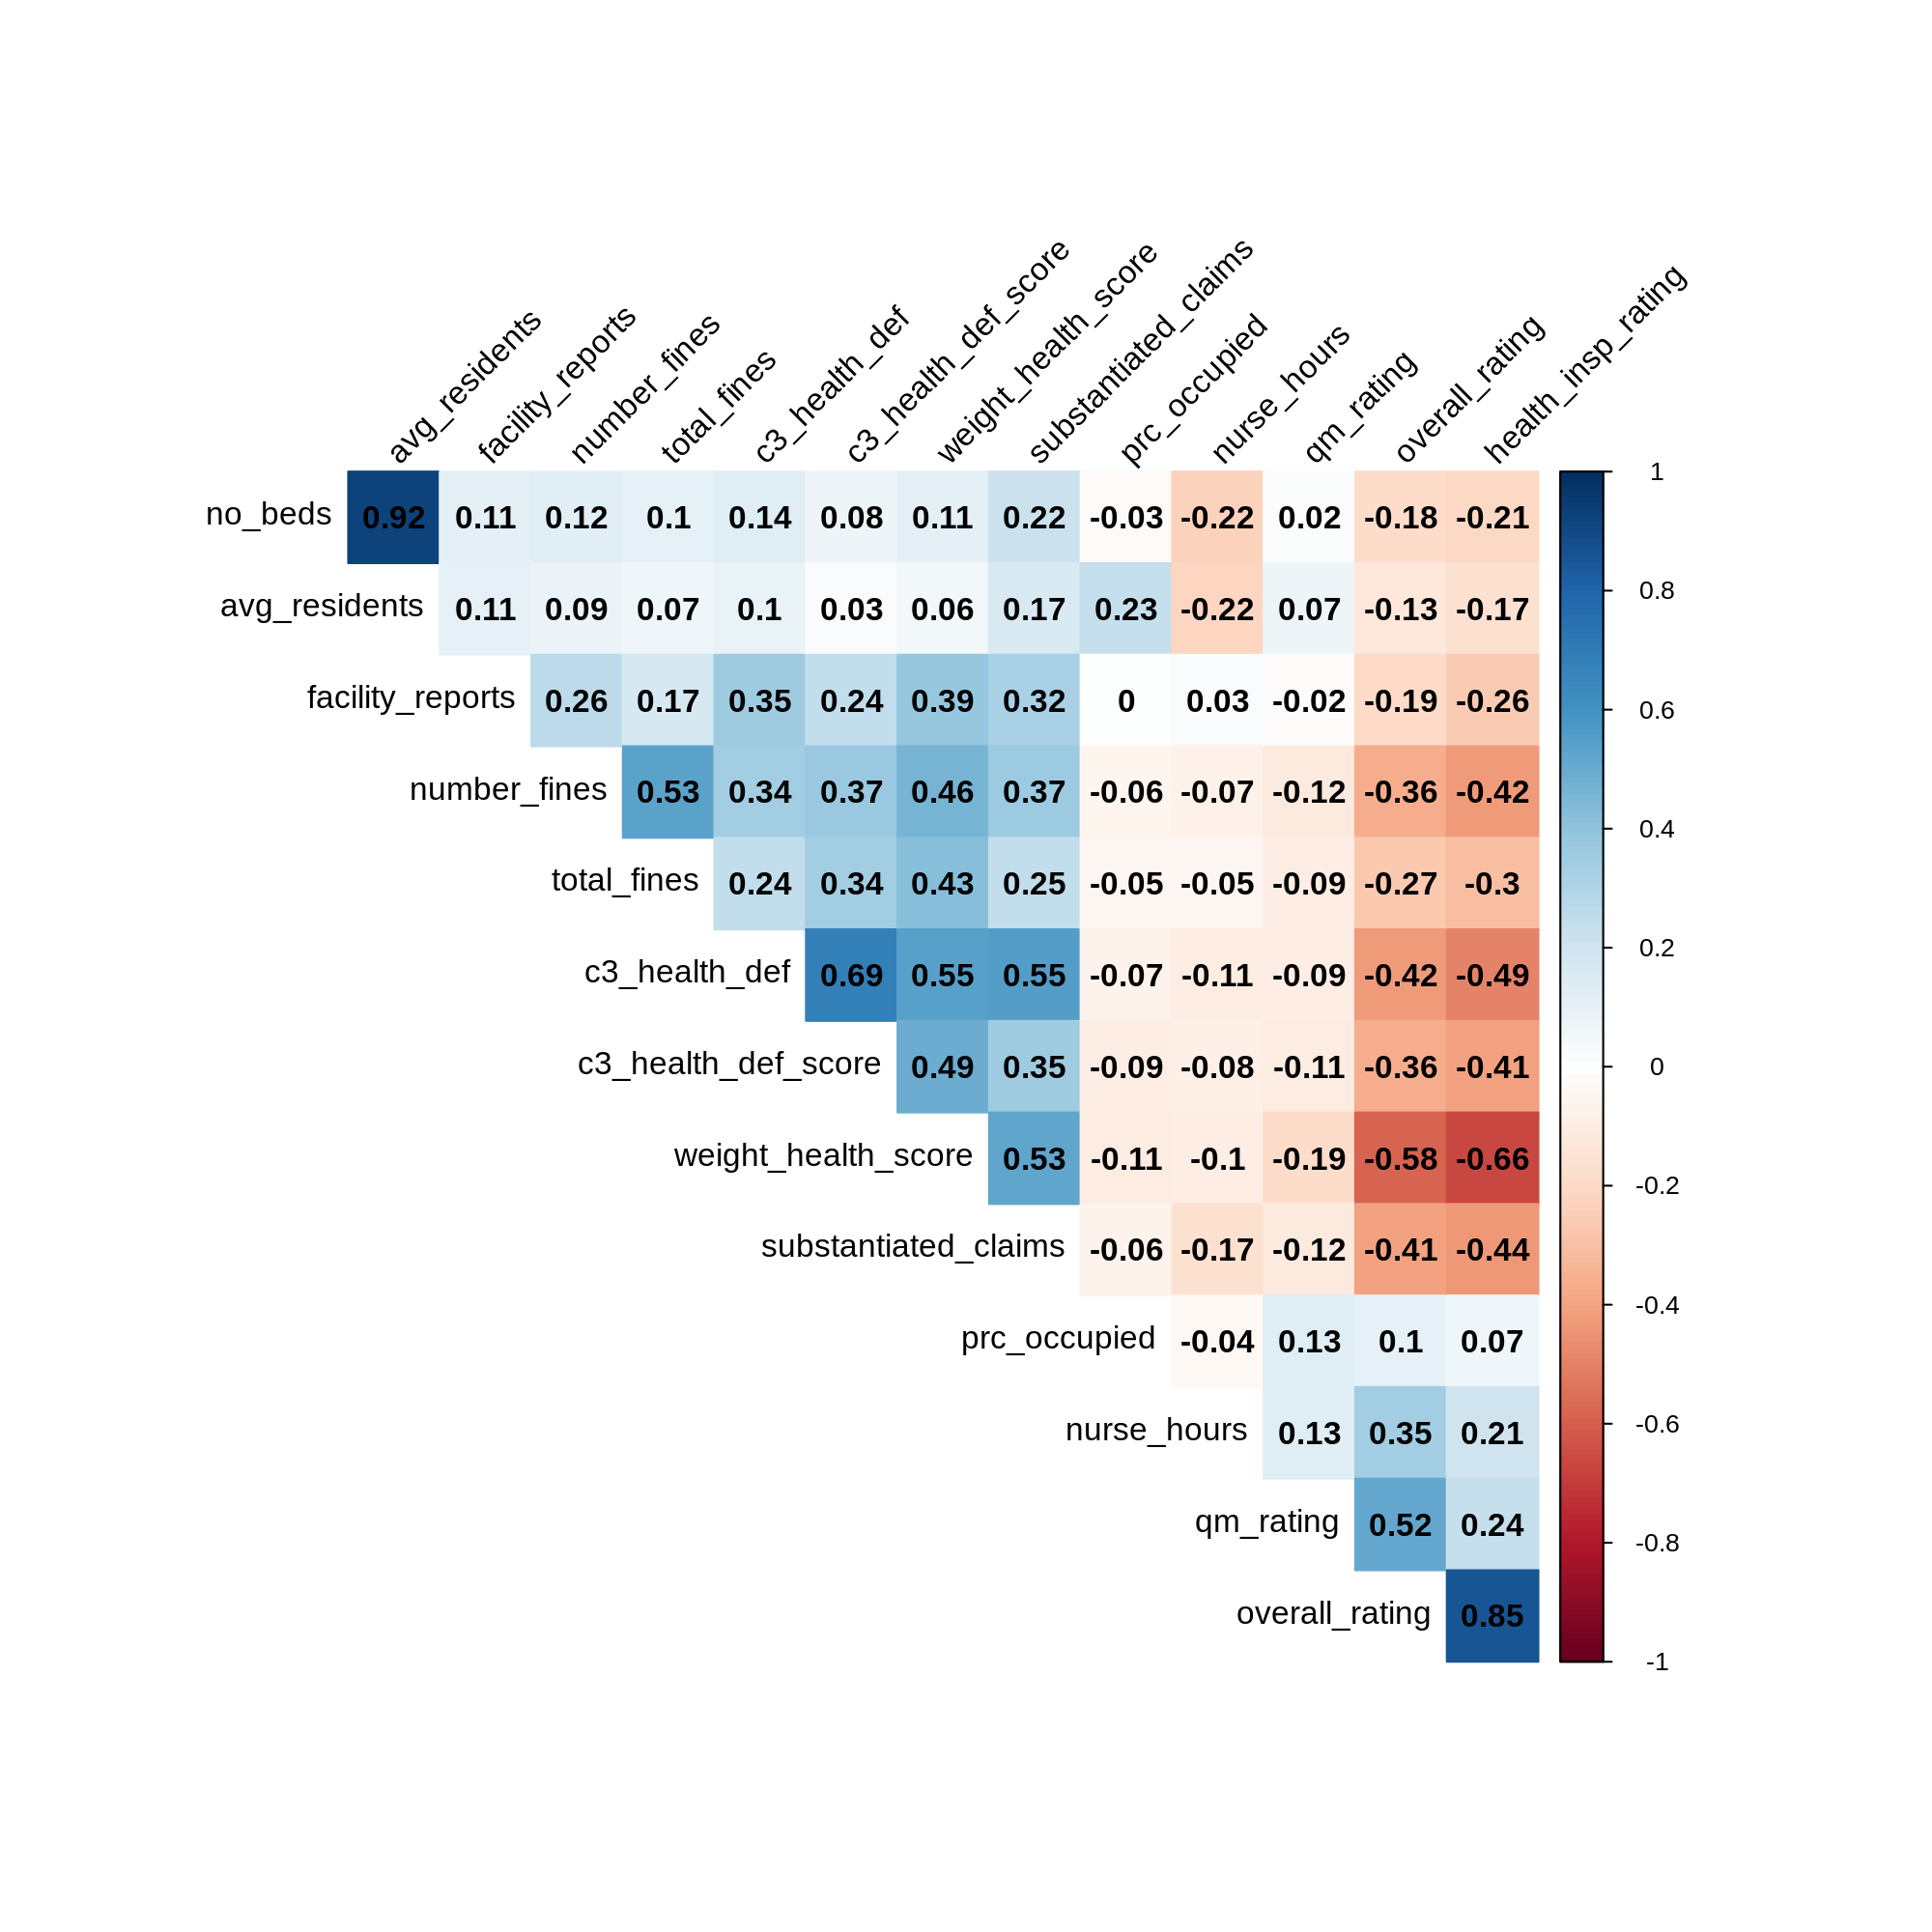

In [81]:
%%R -i cms2 -w 10 -h 10 --units in -r 200

library(corrplot)
corr = cor(cms2[c("no_beds", "avg_residents", "c3_health_def", "c3_health_def_score", 
               "weight_health_score", "overall_rating", "health_insp_rating", "qm_rating", "facility_reports", 
               "substantiated_claims", "number_fines", "total_fines", "nurse_hours", "prc_occupied")], 
          use="pairwise")
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", tl.col="black", tl.srt=45, diag=FALSE)

# only very high correlation is no_beds and avg_residents; 
# will use weighted_health_score, no_beds, prc_occupied, nurse_hours, total_fines, overall_rating

In [82]:
#eighted_health_score, no_beds, prc_occupied, nurse_hours, total_fines, overall_rating
cms2 = cms2[["prov_county", "prov_state", "weight_health_score", "no_beds", "prc_occupied", "nurse_hours", "total_fines", "overall_rating"]]

In [83]:
names = ["county", "state", "weighted_health_score", "num_beds", "prc_occupied", "nurse_hours", "total_fines", "overall_rating"]
for i in range(len(names)):
    names[i] = "nh_" + names[i]
    
cms2.columns = names  

In [84]:
cms2.columns

Index(['nh_county', 'nh_state', 'nh_weighted_health_score', 'nh_num_beds',
       'nh_prc_occupied', 'nh_nurse_hours', 'nh_total_fines',
       'nh_overall_rating'],
      dtype='object')

In [85]:
for field in cms2.columns:
    nas = cms2[pd.isna(cms2[field])]
    print(field, ": ", nas.shape[0])

nh_county :  0
nh_state :  0
nh_weighted_health_score :  95
nh_num_beds :  0
nh_prc_occupied :  69
nh_nurse_hours :  615
nh_total_fines :  0
nh_overall_rating :  180


In [86]:
# use average value for the NAs
for field in ["nh_weighted_health_score", "nh_prc_occupied", "nh_nurse_hours", "nh_overall_rating"]:
    cms2[field].fillna(cms2[field].mean(), inplace=True)

In [87]:
for field in cms2.columns:
    nas = cms2[pd.isna(cms2[field])]
    print(field, ": ", nas.shape[0])

nh_county :  0
nh_state :  0
nh_weighted_health_score :  0
nh_num_beds :  0
nh_prc_occupied :  0
nh_nurse_hours :  0
nh_total_fines :  0
nh_overall_rating :  0


In [88]:
cms2.describe()

,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating
count,15436.0000,15436.0000,15436.0000,15436.0000,1.5436e+04,15436.0000
mean,61.0239,106.2429,81.0498,3.8701,1.4541e+04,3.1682
std,66.8991,60.7812,19.7530,0.8572,4.8768e+04,1.4170
min,0.0000,1.0000,0.9901,1.2159,0.0000e+00,1.0000
25%,21.3330,64.0000,72.7419,3.3199,0.0000e+00,2.0000
50%,42.0000,99.0000,84.8333,3.7872,0.0000e+00,3.0000
75%,76.6670,127.0000,92.1511,4.2374,8.1250e+03,4.0000
max,1408.6700,1389.0000,1338.3333,11.9480,1.2584e+06,5.0000


In [89]:
cms2.columns

Index(['nh_county', 'nh_state', 'nh_weighted_health_score', 'nh_num_beds',
       'nh_prc_occupied', 'nh_nurse_hours', 'nh_total_fines',
       'nh_overall_rating'],
      dtype='object')

In [90]:
# aggregate by county
nursing = dict()

# use county, state as key  
# holds a lits of dictionaries with individual provider's info

for row in cms2.iterrows():
        provider = list()
        state_co = (row[1][0], row[1][1])
        for i in range (2,len(cms2.columns)):
            provider.append(row[1][i])
        
        
        if state_co not in nursing.keys():
            nursing[state_co] = list()
            
        nursing[state_co].append(provider)   


In [91]:
cms2.shape

(15436, 8)

In [92]:
len(nursing.keys()) # 15,436 establishments in 2.896 different counties

2896

In [93]:
nursing[("Middlesex", "NJ")]

[[4.0, 132, 79.01515151515152, 3.91684, 0.0, 5.0],
 [21.333000000000002, 140, 73.85714285714286, 3.75049, 0.0, 2.0],
 [10.0, 108, 91.29629629629629, 4.25949, 0.0, 5.0],
 [30.0, 280, 76.03571428571428, 2.99415, 0.0, 3.0],
 [54.667, 250, 92.52, 3.77202, 0.0, 2.0],
 [13.333, 94, 88.19148936170214, 3.4408, 0.0, 5.0],
 [10.0, 112, 90.53571428571429, 3.4356199999999997, 0.0, 4.0],
 [14.667, 200, 78.85, 3.65125, 7283.0, 5.0],
 [46.0, 328, 88.99390243902438, 4.82515, 0.0, 2.0],
 [12.0, 154, 77.20779220779221, 4.0025, 0.0, 4.0],
 [41.5, 180, 91.38888888888889, 4.11469, 9753.0, 1.0],
 [6.0, 120, 80.58333333333334, 4.07125, 0.0, 4.0],
 [21.333000000000002, 120, 90.25, 4.4361, 20425.0, 4.0],
 [2.0, 120, 82.75, 3.75653, 0.0, 5.0],
 [23.333000000000002, 136, 73.08823529411765, 3.83009, 0.0, 4.0],
 [11.333, 120, 85.24999999999999, 3.64185, 0.0, 5.0],
 [24.666999999999998, 356, 48.061797752808985, 4.8443, 0.0, 4.0],
 [22.666999999999998, 230, 94.34782608695652, 3.53119, 0.0, 3.0],
 [26.666999999999998

In [94]:
# sum nh_num_des, but take weighted average (weighted by nh_num_beds) for all other fields
nh_county = []
nh_state = []
nh_weighted_health_score = [] #0
nh_num_beds = [] #1
nh_prc_occupied = [] #2
nh_nurse_hours = [] #3
nh_total_fines = [] #4
nh_overall_rating = [] #5

for key in nursing.keys():
    nh_county.append(key[0])
    nh_state.append(key[1])
    
    total = 0
    for site in nursing[key]: # nh_num_beds
        total = total + site[1]
    nh_num_beds.append(total)
    
    
    for i, j in zip([0, 2, 3, 4, 5], [nh_weighted_health_score, nh_prc_occupied, nh_nurse_hours, nh_total_fines, nh_overall_rating]):
        weighted = 0
        for site in nursing[key]:
            weighted = weighted + ((site[i] * site[1]) / total)
        j.append(weighted)

In [95]:
cms2 = {'nh_county': nh_county, 'nh_state': nh_state, 
        'nh_weighted_health_score': nh_weighted_health_score, 
        'nh_num_beds': nh_num_beds, 'nh_prc_occupied': nh_prc_occupied,
        'nh_nurse_hours': nh_nurse_hours, 'nh_total_fines': nh_total_fines,
        'nh_overall_rating': nh_overall_rating}

In [96]:
nursing = pd.DataFrame(cms2)

In [97]:
nursing.head()

,nh_county,nh_state,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating
0,Covington,AL,22.5443,436,84.7477,4.1875,0.0000,3.3899
1,Mobile,AL,24.7254,2006,82.8913,4.1345,11904.1545,3.5075
2,Pueblo,CO,78.3311,1174,79.0996,3.5891,33786.6627,2.5571
3,Montezuma,CO,21.3998,161,73.4161,3.8588,0.0000,4.6273
4,Denver,CO,51.6080,2147,84.0615,4.0486,15642.9273,3.7513


In [98]:
nursing.describe()

,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating
count,2896.0000,2896.0000,2896.0000,2896.0000,2896.0000,2896.0000
mean,59.0154,566.2866,78.3893,3.8512,15357.6983,3.0506
std,50.3214,1459.6366,12.9538,0.6519,40048.8081,1.0489
min,0.0000,15.0000,29.6585,1.7896,0.0000,1.0000
25%,26.6670,106.0000,70.6463,3.4106,0.0000,2.2472
50%,46.6236,223.0000,80.9791,3.7765,2716.6871,3.0000
75%,77.2514,470.2500,88.0579,4.1758,14154.5739,3.8582
max,722.2346,38648.0000,160.5263,8.8340,830580.0000,5.0000


In [99]:
nh_weighted_health_score = [] #0
nh_num_beds = [] #1
nh_prc_occupied = [] #2
nh_nurse_hours = [] #3
nh_total_fines = [] #4
nh_overall_rating = [] #5
all_lists = [nh_weighted_health_score, nh_num_beds, nh_prc_occupied, 
             nh_nurse_hours, nh_total_fines, nh_overall_rating]
cols = ['nh_weighted_health_score', 'nh_num_beds',
       'nh_prc_occupied', 'nh_nurse_hours', 'nh_total_fines',
       'nh_overall_rating']
for a, b in zip(counties.county, counties.state):
    subset = nursing[(nursing.nh_county.str.lower() == re.sub(" [^ ]+?$", "", a).lower()) & 
                     (nursing.nh_state == b)]
    
    if subset.shape[0] == 0:
        for l in all_lists:
            l.append(np.NaN)
    elif subset.shape[0] > 1:
        print("{}, {} has more than one entry".format(a, b))
        print(subset)
    else:
        for c, d in zip(cols, all_lists):
            d.append(sum(subset[c]))

In [100]:
nh_weighted_health_score[:10]

[22.78254416403786,
 65.99777064220183,
 62.94465659617321,
 46.23792307692308,
 73.23799052132702,
 79.333,
 73.03027889060091,
 54.00832399710878,
 89.18118559218559,
 99.09678505704821]

In [101]:
for a, b in zip(cols, all_lists):
    counties[a] = b

In [102]:
counties.describe()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,immigrant,area,numericFIPS,prc_obese,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating
count,827.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,838.0000,...,8.2700e+02,827.0000,838.0000,838.0000,803.0000,803.0000,803.0000,803.0000,803.0000,803.0000
mean,2.5905,-2.3847e+06,-2.3663e+06,-2.3492e+06,-2.3705e+06,-2.3714e+06,-2.3688e+06,-2.3777e+06,1.6239e+05,9.3678,...,5.1980e+04,1066.8997,30559.2172,31.0897,69.8115,1525.3724,81.0986,3.8105,21942.4713,2.9956
std,0.2503,4.8824e+07,4.8825e+07,4.8826e+07,4.8825e+07,4.8825e+07,4.8825e+07,4.8824e+07,2.9152e+05,5.2102,...,1.7515e+05,1816.4262,16183.2778,5.2801,48.9992,2528.0736,8.8092,0.4673,36523.8767,0.7550
min,1.9000,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,1.5513e+04,1.3000,...,2.6200e+02,15.0300,1003.0000,14.2000,3.6867,25.0000,40.2120,2.6180,0.0000,1.0000
25%,2.4100,5.0925e+02,3.5752e+03,1.0258e+04,4.0738e+03,4.5378e+03,5.0508e+03,2.2002e+03,4.3710e+04,5.9000,...,3.8610e+03,434.6000,17116.0000,27.7000,35.0382,470.5000,75.4429,3.4715,2661.2968,2.4498
50%,2.5500,9.4000e+02,7.0000e+03,1.7369e+04,7.1555e+03,8.1090e+03,8.9770e+03,3.8195e+03,7.4613e+04,8.5000,...,9.0510e+03,629.0000,34008.0000,31.5500,58.8536,784.0000,82.5559,3.7756,10093.1351,3.0130
75%,2.7100,1.6915e+03,1.8371e+04,3.9902e+04,1.6001e+04,1.5998e+04,1.8470e+04,8.3798e+03,1.6498e+05,11.5000,...,3.1505e+04,909.9550,42096.5000,34.6750,90.2299,1509.0000,87.4912,4.1008,27789.2504,3.5252
max,4.1100,6.6139e+04,6.4235e+05,1.0316e+06,5.8385e+05,4.5555e+05,5.0494e+05,3.1794e+05,5.0014e+06,49.2000,...,3.4400e+06,24607.9000,72139.0000,47.7000,563.0000,38648.0000,112.4693,6.6052,470742.1226,5.0000


In [103]:
# substitute column mean for NAs in newly added data 

for field in cols:
    counties[field].fillna(counties[field].mean(), inplace=True)

## Add Prison and Jail Population Data

In [104]:
jail = pd.read_csv("incarceration_trends_jail_jurisdiction.txt")

In [105]:
jail.head()

,Unnamed: 0,yjid,jid,fips,total_jail_pop,female_jail_pop,male_jail_pop,female_juvenile_jail_pop,male_juvenile_jail_pop,aapi_jail_pop,...,total_jail_from_ice,total_jail_from_marshals,total_jail_from_other_fed,jail_rated_capacity,private_jail_flag,regional_jail_flag,total_jail_adm,total_jail_dis,year,jurisdiction_name
0,0,197001001001,1001001,1001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,AUTAUGA METRO JAIL
1,1,197101001001,1001001,1001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1971,AUTAUGA METRO JAIL
2,2,197201001001,1001001,1001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,AUTAUGA METRO JAIL
3,3,197301001001,1001001,1001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1973,AUTAUGA METRO JAIL
4,4,197401001001,1001001,1001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1974,AUTAUGA METRO JAIL


In [106]:
jail.drop("Unnamed: 0", axis=1, inplace=True)

In [107]:
jail = jail[jail.year >= 2010]

In [108]:
jail.describe()

,yjid,jid,fips,total_jail_pop,female_jail_pop,male_jail_pop,female_juvenile_jail_pop,male_juvenile_jail_pop,aapi_jail_pop,black_jail_pop,...,total_jail_from_bop,total_jail_from_ice,total_jail_from_marshals,total_jail_from_other_fed,jail_rated_capacity,private_jail_flag,regional_jail_flag,total_jail_adm,total_jail_dis,year
count,3.3808e+04,3.3808e+04,33808.0000,23680.0000,23282.0000,23282.0000,23267.0000,23267.0000,23644.0000,23644.0000,...,23608.0000,23650.0000,23644.0000,23650.0000,23696.0000,504.0,0.0,23267.0000,23267.0000,33808.0000
mean,2.0138e+11,2.9104e+07,29103.7350,252.9814,32.1686,213.5146,0.1493,1.5864,2.6764,88.9374,...,0.6635,5.7815,8.5626,0.6432,304.3157,1.0,NaN,3749.6805,3622.8013,2013.5000
std,2.2967e+08,1.5715e+07,15714.6681,684.6408,74.2531,583.8984,0.9872,8.1917,14.1762,320.2760,...,8.5388,42.9013,41.4594,8.9312,816.3711,0.0,NaN,8268.4174,8223.9577,2.2913
min,2.0100e+11,1.0010e+06,1001.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,NaN,0.0000,0.0000,2010.0000
25%,2.0119e+11,1.7079e+07,17079.0000,24.5000,2.0000,20.0000,0.0000,0.0000,0.0000,1.7700,...,0.0000,0.0000,0.0000,0.0000,34.0000,1.0,NaN,468.0000,364.0000,2011.7500
50%,2.0138e+11,2.9052e+07,29052.0000,79.0000,9.0000,65.0000,0.0000,0.0000,0.0000,9.7500,...,0.0000,0.0000,0.0000,0.0000,102.5600,1.0,NaN,1316.0000,1196.0000,2013.5000
75%,2.0157e+11,4.2067e+07,42067.0000,220.0000,30.0000,184.0000,0.0000,0.0000,1.3000,52.0000,...,0.0000,0.0000,0.0000,0.0000,262.0000,1.0,NaN,3588.0000,3423.5000,2015.2500
max,2.0176e+11,5.6045e+07,56045.0000,18930.0000,1329.0000,16572.0000,58.0000,393.0000,341.4800,7272.0000,...,624.0000,1175.0000,1434.0000,476.0000,22612.0000,1.0,NaN,150904.0000,157248.0000,2017.0000


In [109]:
jail=jail[["fips", "total_jail_pop", "year", "jurisdiction_name"]]
jail = jail[jail.year == 2017]

In [110]:
jail_pop = list()

for fips in counties.numericFIPS:
    pops = jail[jail.fips == fips].total_jail_pop
    if len(pops) > 0:
        pops = pops.fillna(0)
        jail_pop.append(sum(pops))
    else:
        jail_pop.append(0)  

In [111]:
counties["incarcerated"] = jail_pop

In [112]:
counties.describe()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,area,numericFIPS,prc_obese,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating,incarcerated
count,827.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,838.0000,...,827.0000,838.0000,838.0000,838.0000,838.0000,838.0000,838.0000,838.0000,838.0000,838.0000
mean,2.5905,-2.3847e+06,-2.3663e+06,-2.3492e+06,-2.3705e+06,-2.3714e+06,-2.3688e+06,-2.3777e+06,1.6239e+05,9.3678,...,1066.8997,30559.2172,31.0897,69.8115,1525.3724,81.0986,3.8105,21942.4713,2.9956,681.1933
std,0.2503,4.8824e+07,4.8825e+07,4.8826e+07,4.8825e+07,4.8825e+07,4.8825e+07,4.8824e+07,2.9152e+05,5.2102,...,1816.4262,16183.2778,5.2801,47.9637,2474.6522,8.6230,0.4574,35752.0808,0.7391,1122.0011
min,1.9000,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,1.5513e+04,1.3000,...,15.0300,1003.0000,14.2000,3.6867,25.0000,40.2120,2.6180,0.0000,1.0000,0.0000
25%,2.4100,5.0925e+02,3.5752e+03,1.0258e+04,4.0738e+03,4.5378e+03,5.0508e+03,2.2002e+03,4.3710e+04,5.9000,...,434.6000,17116.0000,27.7000,35.8851,487.0000,76.0543,3.4834,2775.4065,2.4757,204.2500
50%,2.5500,9.4000e+02,7.0000e+03,1.7369e+04,7.1555e+03,8.1090e+03,8.9770e+03,3.8195e+03,7.4613e+04,8.5000,...,629.0000,34008.0000,31.5500,61.8703,816.0000,82.1340,3.8036,11256.0452,2.9956,375.0000
75%,2.7100,1.6915e+03,1.8371e+04,3.9902e+04,1.6001e+04,1.5998e+04,1.8470e+04,8.3798e+03,1.6498e+05,11.5000,...,909.9550,42096.5000,34.6750,89.1568,1525.3724,87.3356,4.0908,26301.4340,3.5049,741.5000
max,4.1100,6.6139e+04,6.4235e+05,1.0316e+06,5.8385e+05,4.5555e+05,5.0494e+05,3.1794e+05,5.0014e+06,49.2000,...,24607.9000,72139.0000,47.7000,563.0000,38648.0000,112.4693,6.6052,470742.1226,5.0000,17367.0000


In [113]:
counties.drop("numericFIPS", inplace=True, axis=1)

### Airport Passenger Volume Data
Add airport data for the 200-something airports from data ranking at https://www.bts.gov/airport-rankings-2018

In [114]:
airports = pd.read_csv("passengers.csv")

In [115]:
airports.describe()

,"2018 Scheduled Enplanements Domestic Passengers (000,000)",2018 Scheduled Emplanements International Passengers (000)
count,200.0000,48.0000
mean,3.8382,2373.6792
std,6.8996,3483.3706
min,0.1450,101.9000
25%,0.3492,197.2500
50%,0.7980,563.6500
75%,3.4653,3257.1250
max,45.7110,16459.9000


In [116]:
airports.head()

,Airport,IATA,"2018 Scheduled Enplanements Domestic Passengers (000,000)",2018 Scheduled Emplanements International Passengers (000)
0,Atlanta,ATL,45.711,6133.5
1,Chicago O'Hare,ORD,33.144,6707.4
2,Los Angeles,LAX,30.008,12570.6
3,Denver,DEN,29.883,1458.9
4,Dallas/Fort Worth,DFW,28.641,4138.7


Getting the lat/long for each airport from data file from OpenFlights: https://github.com/jpatokal/openflights and described at https://openflights.org/data.html

In [117]:
air_locs = pd.read_csv("airports.dat", header=None)

In [118]:
air_locs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.0817,145.392,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.2071,145.789,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.8268,144.296,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.5698,146.726,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.4434,147.220,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [119]:
air_locs.columns = ['openflights_id', 'name', 'city', 'country', 'IATA', 'ICAO', 'lat', 
                    'lng', 'alt', 'timezone', 'DST', 'Tz', 'type', 'source']

In [120]:
air_locs = air_locs[air_locs['country'] == 'United States']
air_locs.head()

,openflights_id,name,city,country,IATA,ICAO,lat,lng,alt,timezone,DST,Tz,type,source
3212,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,PABA,70.1340,-143.582,2,-9,A,America/Anchorage,airport,OurAirports
3213,3412,Wainwright Air Station,Fort Wainwright,United States,\N,PAWT,70.6134,-159.860,35,-9,A,America/Anchorage,airport,OurAirports
3214,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,PALU,68.8751,-166.110,16,-9,A,America/Anchorage,airport,OurAirports
3215,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,PPIZ,69.7329,-163.005,22,-9,A,America/Anchorage,airport,OurAirports
3216,3415,Hilo International Airport,Hilo,United States,ITO,PHTO,19.7214,-155.048,38,-10,N,Pacific/Honolulu,airport,OurAirports


In [121]:
lat = list()
long = list()

for x in range(airports.shape[0]):
    result_lat = air_locs.loc[air_locs["IATA"] == airports.iloc[x]['IATA'], "lat"]
    result_lng = air_locs.loc[air_locs["IATA"] == airports.iloc[x]['IATA'], "lng"]
    try:
        value_lat = float(result_lat)
        lat.append(value_lat)
    except:
        lat.append(None)
        
    try:
        value_lng = float(result_lng)
        long.append(value_lng)
    except:
        long.append(None)

In [122]:
airports["lat"] = lat
airports["long"] = long

In [123]:
airports.head()

,Airport,IATA,"2018 Scheduled Enplanements Domestic Passengers (000,000)",2018 Scheduled Emplanements International Passengers (000),lat,long
0,Atlanta,ATL,45.711,6133.5,33.6367,-84.4281
1,Chicago O'Hare,ORD,33.144,6707.4,41.9786,-87.9048
2,Los Angeles,LAX,30.008,12570.6,33.9425,-118.4080
3,Denver,DEN,29.883,1458.9,39.8617,-104.6730
4,Dallas/Fort Worth,DFW,28.641,4138.7,32.8968,-97.0380


In [124]:
airports.tail()

,Airport,IATA,"2018 Scheduled Enplanements Domestic Passengers (000,000)",2018 Scheduled Emplanements International Passengers (000),lat,long
195,Jacksonville/Camp Lejeune,OAJ,0.151,NaN,34.8292,-77.6121
196,Latrobe,LBE,0.150,NaN,40.2759,-79.4048
197,Minot,MOT,0.148,NaN,48.2594,-101.2800
198,Lincoln,LNK,0.146,NaN,40.8510,-96.7592
199,Concord,USA,0.145,NaN,35.3878,-80.7091


In [125]:
# convert NaN to 0 in passenger columns

airports[["2018 Scheduled Enplanements Domestic Passengers (000,000)",
          "2018 Scheduled Emplanements International Passengers (000)"]] = airports[["2018 Scheduled Enplanements Domestic Passengers (000,000)",
          "2018 Scheduled Emplanements International Passengers (000)"]].fillna(0)


Convert the lat/long for each airport into the appropriate county, state using package uszipcode

I want calculate the number of domestic and international airline passengers that arrive within 20 miles of each county.

In [126]:
search = SearchEngine()
passengers = dict()

for x in range((airports.shape[0])):
    # first use lat, long for each airport, and search for its zipcode, and use to get all 
    # zipcodes within 20 mile radius of the airport
    result = search.by_coordinates(airports.loc[x, "lat"], airports.loc[x, "long"], 
                                   radius=20, returns=700)
    
    # get set of county, state tuples within a 20 mile radius of this airport from zipcode info
    unique = set()
    for y in range(len(result)):
        co = result[y].to_dict()["county"]
        st = result[y].to_dict()["state"]
        unique.add((co, st))
    
    # for each unique county found, either add to passengers dict with domestic and
    # international passenger count, or if already in passengers dict add the
    # dom and intl passenger counts to those already in the dictionary
    for y in unique:
        if y in passengers.keys():
            temp = passengers[y]
            temp["dom"] = temp["dom"] + (airports.loc[x, "2018 Scheduled Enplanements Domestic Passengers (000,000)"] * 1000000)
            temp["intl"] = temp["intl"] + (airports.loc[x, "2018 Scheduled Emplanements International Passengers (000)"] * 1000)
            passengers[y] = temp
        else:
            temp = dict()
            temp["dom"] = airports.loc[x, "2018 Scheduled Enplanements Domestic Passengers (000,000)"] * 1000000
            temp["intl"] = airports.loc[x, "2018 Scheduled Emplanements International Passengers (000)"] * 1000
            passengers[y] = temp

In [127]:
# convert passengers dictionary into a data frame
co = list()
st = list()
dom = list()
intl = list()

for x in passengers.keys():
    co.append(x[0])
    st.append(x[1])
    dom.append(int(passengers[x]["dom"])) # convert to integer
    intl.append(int(passengers[x]["intl"]))

ps = {"county":co, "state":st, "dom passengers":dom, "intl passengers":intl}
passengers = pd.DataFrame(ps)

In [128]:
passengers.head()

,county,state,dom passengers,intl passengers
0,DeKalb County,GA,45711000,6133500
1,Clayton County,GA,45711000,6133500
2,Coweta County,GA,45711000,6133500
3,Rockdale County,GA,45711000,6133500
4,Cobb County,GA,45711000,6133500


Add the airport data to the census/county data

In [129]:
domestic = list()
international = list()

for x in range(counties.shape[0]):
    result_dom = passengers.loc[(passengers["county"] == counties.iloc[x]["county"]) & (passengers["state"] == counties.iloc[x]["state"]), "dom passengers"]
    result_int = passengers.loc[(passengers["county"] == counties.iloc[x]["county"]) & (passengers["state"] == counties.iloc[x]["state"]), "intl passengers"]
    
    if (len(result_dom) > 1 or len(result_int) > 1):
        print("unusual at x = ", x) # should only be one value for counties with any passengers
    domestic.append(result_dom.sum()) # use sum to convert empty series to 0
    international.append(result_int.sum()) 

In [130]:
counties["domestic_passengers"] = domestic
counties["intl_passengers"] = international

In [131]:
counties.head()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,prc_obese,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating,incarcerated,domestic_passengers,intl_passengers
"Morgan County, Alabama: Summary level: 050, state:01> county:103",2.56,580,6009,10431,4473,11938,5507,3039,53742,9.9,...,32.1,22.7825,634.0,93.6435,3.7760,11365.9164,3.0521,604.0,580000,0
"Kings County, California: Summary level: 050, state:06> county:031",3.15,7797,3901,11372,4707,3752,4899,2329,52644,15.6,...,29.4,65.9978,327.0,77.8899,4.1673,0.0000,3.3792,465.0,0,0
"Monterey County, California: Summary level: 050, state:06> county:053",3.31,30494,19232,37518,20736,12420,17109,7415,190707,10.5,...,27.6,62.9447,993.0,86.1531,4.1465,9445.8439,3.6959,929.0,186000,0
"Nevada County, California: Summary level: 050, state:06> county:057",2.37,596,7285,9199,5133,1562,4717,3022,44505,5.1,...,21.5,46.2379,429.0,86.1305,4.4692,1140.6667,4.6317,197.0,0,0
"Shasta County, California: Summary level: 050, state:06> county:089",2.59,743,6543,17734,7999,3077,8953,3488,69649,9.5,...,23.3,73.2380,1055.0,84.3791,4.5562,23127.3251,3.7697,339.0,0,0


### Shelter-in-Place Order Data

add data about when states/counties began shelter-in-place/stay-at-hom orders.

Data was manually entered into CSV files from:
+ https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html
+ https://www.sfchronicle.com/bayarea/article/Bay-Area-to-shelter-in-place-What-you-need-15135087.php
+ https://www.acgov.org/documents/Final-Order-to-Shelter-In-Place.pdf




In [132]:
# start with county/cities first, since more specific and earlier 
# (if there were subsequent, superceding state-level orders, like in California)

county = pd.read_csv("county_orders.csv")
state = pd.read_csv("state_orders.csv")

In [133]:
county.tail()

,state,county,city,date order started (MM/DD/YY)
15,CA,Marin County,NaN,03/17/20
16,CA,Sonoma County,NaN,03/17/20
17,CA,Solano County,NaN,03/17/20
18,CA,Napa County,NaN,03/17/20
19,CA,Contra Costa County,NaN,03/17/20


In [134]:
state.head()

,state,date order started (MM/DD/YY)
0,AL,04/04/20
1,AK,03/28/20
2,AZ,03/31/20
3,CA,03/19/20
4,CO,03/26/20


In [135]:
st = counties.iloc[0]["state"]
co = counties.iloc[0]["county"]
co

'Morgan County'

In [136]:
counties.loc[counties["county"] == "Alameda County"]

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,prc_obese,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating,incarcerated,domestic_passengers,intl_passengers
"Alameda County, California: Summary level: 050, state:06> county:001",2.84,4405,180270,192425,72367,86012,76344,44602,882648,5.1,...,19.2,42.6809,5738.0,85.244,4.4888,4822.8899,4.1231,2520.0,33736000,7714000


In [137]:
# figure out how to access everything...
st = counties.loc[counties["county"] == "Alameda County", "state"].values[0]
co = counties.loc[counties["county"] == "Alameda County", "county"].values[0]
print(str(co), "\t", str(st))

Alameda County 	 CA


In [138]:
result = county.loc[(county["state"] == st) & (county["county"] == co), "date order started (MM/DD/YY)"].values
result

array(['03/17/20'], dtype=object)

In [139]:
orders = list()

for x in range(counties.shape[0]):
    st = counties.iloc[x]["state"]
    co = counties.iloc[x]["county"]
    
    # check if in the counties set first
    date = county.loc[(county["state"] == st) & (county["county"] == co), "date order started (MM/DD/YY)"].values
    if len(date) > 0:
        orders.append(date[0])
    else:
        date = state.loc[state["state"] == st, "date order started (MM/DD/YY)"].values
        if len(date) > 0:
            orders.append(date[0])
        else:
            orders.append(None)

In [140]:
counties["order started"] = orders

In [141]:
counties.head()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating,incarcerated,domestic_passengers,intl_passengers,order started
"Morgan County, Alabama: Summary level: 050, state:01> county:103",2.56,580,6009,10431,4473,11938,5507,3039,53742,9.9,...,22.7825,634.0,93.6435,3.7760,11365.9164,3.0521,604.0,580000,0,04/04/20
"Kings County, California: Summary level: 050, state:06> county:031",3.15,7797,3901,11372,4707,3752,4899,2329,52644,15.6,...,65.9978,327.0,77.8899,4.1673,0.0000,3.3792,465.0,0,0,03/19/20
"Monterey County, California: Summary level: 050, state:06> county:053",3.31,30494,19232,37518,20736,12420,17109,7415,190707,10.5,...,62.9447,993.0,86.1531,4.1465,9445.8439,3.6959,929.0,186000,0,03/19/20
"Nevada County, California: Summary level: 050, state:06> county:057",2.37,596,7285,9199,5133,1562,4717,3022,44505,5.1,...,46.2379,429.0,86.1305,4.4692,1140.6667,4.6317,197.0,0,0,03/19/20
"Shasta County, California: Summary level: 050, state:06> county:089",2.59,743,6543,17734,7999,3077,8953,3488,69649,9.5,...,73.2380,1055.0,84.3791,4.5562,23127.3251,3.7697,339.0,0,0,03/19/20


In [142]:
counties.describe()

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,prc_obese,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating,incarcerated,domestic_passengers,intl_passengers
count,827.0000,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,8.3800e+02,838.0000,...,838.0000,838.0000,838.0000,838.0000,838.0000,838.0000,838.0000,838.0000,8.3800e+02,8.3800e+02
mean,2.5905,-2.3847e+06,-2.3663e+06,-2.3492e+06,-2.3705e+06,-2.3714e+06,-2.3688e+06,-2.3777e+06,1.6239e+05,9.3678,...,31.0897,69.8115,1525.3724,81.0986,3.8105,21942.4713,2.9956,681.1933,4.1524e+06,7.4442e+05
std,0.2503,4.8824e+07,4.8825e+07,4.8826e+07,4.8825e+07,4.8825e+07,4.8825e+07,4.8824e+07,2.9152e+05,5.2102,...,5.2801,47.9637,2474.6522,8.6230,0.4574,35752.0808,0.7391,1122.0011,9.2267e+06,2.9233e+06
min,1.9000,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,-1.0000e+09,1.5513e+04,1.3000,...,14.2000,3.6867,25.0000,40.2120,2.6180,0.0000,1.0000,0.0000,0.0000e+00,0.0000e+00
25%,2.4100,5.0925e+02,3.5752e+03,1.0258e+04,4.0738e+03,4.5378e+03,5.0508e+03,2.2002e+03,4.3710e+04,5.9000,...,27.7000,35.8851,487.0000,76.0543,3.4834,2775.4065,2.4757,204.2500,0.0000e+00,0.0000e+00
50%,2.5500,9.4000e+02,7.0000e+03,1.7369e+04,7.1555e+03,8.1090e+03,8.9770e+03,3.8195e+03,7.4613e+04,8.5000,...,31.5500,61.8703,816.0000,82.1340,3.8036,11256.0452,2.9956,375.0000,2.9000e+05,0.0000e+00
75%,2.7100,1.6915e+03,1.8371e+04,3.9902e+04,1.6001e+04,1.5998e+04,1.8470e+04,8.3798e+03,1.6498e+05,11.5000,...,34.6750,89.1568,1525.3724,87.3356,4.0908,26301.4340,3.5049,741.5000,2.1800e+06,0.0000e+00
max,4.1100,6.6139e+04,6.4235e+05,1.0316e+06,5.8385e+05,4.5555e+05,5.0494e+05,3.1794e+05,5.0014e+06,49.2000,...,47.7000,563.0000,38648.0000,112.4693,6.6052,470742.1226,5.0000,17367.0000,4.5711e+07,2.4424e+07


In [143]:
for a, b in zip(counties.columns, counties.mean()):
    if b < 0:
        print(a)
        
# per "using ACS data" info, negative values for these fields should be interpreted as 0: 
# https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018.pdf

empl_agriculture
empl_professional
empl_social
empl_services
empl_manufacturing
empl_retail
empl_transp_utilities
prc_public_transp
aa_and_mixed
aa


In [144]:
for field in ["empl_agriculture", "empl_professional","empl_social", "empl_services",
              "empl_manufacturing", "empl_retail", "empl_transp_utilities", 
              "prc_public_transp", "aa_and_mixed", "aa"]:
    counties.loc[counties[field] < 0, field] = 0

### convert certain columns to percentages rather than raw counts

+ convert empl_... into percent empl_.../employed
+ convert pop_65_plus and health_ins into percent pop_65_plus/population, ...

In [145]:
counties.columns.values

array(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing',
       'empl_retail', 'empl_transp_utilities', 'employed',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'aa_and_mixed', 'aa', 'latino',
       'immigrant', 'county', 'state', 'FIPS', 'area', 'prc_obese',
       'nh_weighted_health_score', 'nh_num_beds', 'nh_prc_occupied',
       'nh_nurse_hours', 'nh_total_fines', 'nh_overall_rating',
       'incarcerated', 'domestic_passengers', 'intl_passengers',
       'order started'], dtype=object)

In [146]:
counties["empl_agriculture"] = counties["empl_agriculture"] / counties["employed"] * 100
counties["empl_professional"] = counties["empl_professional"] / counties["employed"] * 100
counties["empl_social"] = counties["empl_social"] / counties["employed"] * 100
counties["empl_services"] = counties["empl_services"] / counties["employed"] * 100
counties["empl_manufacturing"] = counties["empl_manufacturing"] / counties["employed"] * 100
counties["empl_retail"] = counties["empl_retail"] / counties["employed"] * 100
counties["empl_transp_utilities"] = counties["empl_transp_utilities"] / counties["employed"] * 100

In [147]:
counties.head(2)

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating,incarcerated,domestic_passengers,intl_passengers,order started
"Morgan County, Alabama: Summary level: 050, state:01> county:103",2.56,1.0792,11.1812,19.4094,8.3231,22.2135,10.2471,5.6548,53742,9.9,...,22.7825,634.0,93.6435,3.7760,11365.9164,3.0521,604.0,580000,0,04/04/20
"Kings County, California: Summary level: 050, state:06> county:031",3.15,14.8108,7.4102,21.6017,8.9412,7.1271,9.3059,4.4241,52644,15.6,...,65.9978,327.0,77.8899,4.1673,0.0000,3.3792,465.0,0,0,03/19/20


In [148]:
counties["pop_65_plus"] = counties["pop_65_plus"] / counties["population"] * 100
counties["health_ins"] = counties["health_ins"] / counties["population"] * 100
counties["immigrant"] = counties["immigrant"] / counties["population"] * 100
counties["aa"] = counties["aa"] / counties["population"] * 100
counties["aa_and_mixed"] = counties["aa_and_mixed"] / counties["population"] * 100
counties["latino"] = counties["latino"] / counties["population"] * 100

In [149]:
counties.head(2)

,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,employed,prc_fam_poverty,...,nh_weighted_health_score,nh_num_beds,nh_prc_occupied,nh_nurse_hours,nh_total_fines,nh_overall_rating,incarcerated,domestic_passengers,intl_passengers,order started
"Morgan County, Alabama: Summary level: 050, state:01> county:103",2.56,1.0792,11.1812,19.4094,8.3231,22.2135,10.2471,5.6548,53742,9.9,...,22.7825,634.0,93.6435,3.7760,11365.9164,3.0521,604.0,580000,0,04/04/20
"Kings County, California: Summary level: 050, state:06> county:031",3.15,14.8108,7.4102,21.6017,8.9412,7.1271,9.3059,4.4241,52644,15.6,...,65.9978,327.0,77.8899,4.1673,0.0000,3.3792,465.0,0,0,03/19/20


In [150]:
counties.to_csv("counties.csv")